In [1]:
import pandas as pd
from numpy import nan
import numpy as np
import matplotlib.pyplot as plt

import constant

# Windmill Preprocessing
## Clean and prepare windmill data for GIS

In [2]:
# static cols
cols = ['GSRN','Turbine_type','Parent_GSRN','BBR_municipal','Placement','UTM_x','UTM_y','Capacity_kw','Rotor_diameter','Navhub_height','In_service','Out_service']

In [3]:
windmills = pd.read_parquet('data/ITU_DATA/masterdatawind.parquet', columns=cols)

In [4]:
windmills.sort_values(["In_service"])

,GSRN,Turbine_type,Parent_GSRN,BBR_municipal,Placement,UTM_x,UTM_y,Capacity_kw,Rotor_diameter,Navhub_height,In_service,Out_service
79776,571313114900743984,H,None,707,None,NaN,NaN,10.0,7.1,21.4,1816-03-29 05:56:08.067,NaT
85086,571313174116253585,W,None,265,LAND,694932.0,6175477.0,850.0,52.0,44.0,1816-03-29 05:56:08.067,NaT
85087,571313174116253585,W,None,265,LAND,694932.0,6175477.0,850.0,52.0,44.0,1816-03-29 05:56:08.067,NaT
79777,571313114900743984,H,None,707,None,NaN,NaN,10.0,7.1,21.4,1816-03-29 05:56:08.067,NaT
6507,570714700000011283,W,None,400,LAND,505771.2,6109811.3,30.0,0.1,0.1,1977-12-22 00:00:00.000,2002-11-01
...,...,...,...,...,...,...,...,...,...,...,...,...
85021,571313174002139191,H,None,336,None,NaN,NaN,5.0,2.9,3.1,NaT,NaT
85139,571313179100992129,H,None,250,None,NaN,NaN,25.0,11.0,23.5,NaT,NaT
85140,571313179100992129,H,None,250,None,NaN,NaN,25.0,11.0,23.5,NaT,NaT
85141,571313179100992129,H,None,250,None,NaN,NaN,25.0,11.0,23.5,NaT,NaT


### Select windmills still service

In [5]:
windmills = windmills[windmills['Out_service'].isna()]
windmills = windmills.drop(columns = "Out_service")

### Remove duplicated data
Windmills have duplicated data by different reviewers.    

In [6]:
windmills.drop_duplicates(subset = "GSRN", keep = 'first', ignore_index = True, inplace = True)

Household windmills has no coordinates, filter it out

In [7]:
windmills = windmills[windmills['Turbine_type'] != 'H']

### Fill Turbine park xy by the CENTRIODs of their children's.
### Fill Turbine park Rotor_diameter, Navhub_height by the mean of their children's.

In [8]:
windmills_M = windmills[windmills['Turbine_type'] == 'M']
aggs = {'UTM_x':lambda x : x.mean(),
        'UTM_y':lambda x : x.mean()}
windmills_PM = windmills_M.groupby(['Parent_GSRN'], as_index = False).agg(aggs).rename(columns={'Parent_GSRN':'GSRN','UTM_x':'x_c','UTM_y':'y_c'})

temp_1 = pd.DataFrame(windmills_M.groupby("Parent_GSRN")["Rotor_diameter"].apply(list)).reset_index()
temp_2 = pd.DataFrame(windmills_M.groupby("Parent_GSRN")["Navhub_height"].apply(list)).reset_index()
temp_1 = pd.merge(temp_1, temp_2, on="Parent_GSRN")
temp_1 = temp_1.rename({"Parent_GSRN":"GSRN","Rotor_diameter":"Rotor_diameter_mean", "Navhub_height":"Navhub_height_mean"}, axis=1)
temp_1["Rotor_diameter_mean"] = temp_1["Rotor_diameter_mean"].apply(lambda x: np.mean(x).astype(float))
temp_1["Navhub_height_mean"] = temp_1["Navhub_height_mean"].apply(lambda x: np.mean(x).astype(float))
windmills_PM = pd.merge(windmills_PM, temp_1, on="GSRN")
windmills_PM

,GSRN,x_c,y_c,Rotor_diameter_mean,Navhub_height_mean
0,570714700000005640,642373.900000,6.139972e+06,23.0,30.0
1,570714700000012037,664423.733000,6.072868e+06,48.0,45.0
2,570714700000012051,664630.731000,6.072840e+06,48.0,45.0
3,570714700000050008,684100.400000,6.097951e+06,40.0,45.0
4,570714700000050015,636349.972727,6.093533e+06,35.0,37.5
...,...,...,...,...,...
502,570715000000089299,664492.611111,6.048460e+06,92.6,80.0
503,570715000000258107,636075.348135,6.275118e+06,120.0,81.6
504,570715000001613493,415507.469388,6.172906e+06,164.0,105.0
505,570715000001761682,464444.000000,6.283758e+06,12.5,18.5


In [9]:
windmills = pd.merge(windmills, windmills_PM, on='GSRN', how='left')
# location
windmills[['UTM_x']] = windmills.apply(lambda x: x[['UTM_x']].fillna(value = x['x_c']), axis=1)[['UTM_x']]
windmills[['UTM_y']] = windmills.apply(lambda x: x[['UTM_y']].fillna(value = x['y_c']), axis=1)[['UTM_y']]
windmills[['Rotor_diameter']] = windmills.apply(lambda x: x[['Rotor_diameter']].fillna(value = x['Rotor_diameter_mean']), axis=1)[['Rotor_diameter']]
windmills[['Navhub_height']] = windmills.apply(lambda x: x[['Navhub_height']].fillna(value = x['Navhub_height_mean']), axis=1)[['Navhub_height']]
windmills = windmills.drop(columns=['x_c','y_c','Rotor_diameter_mean','Navhub_height_mean'])

Filter out other no coordinate windmills or parks

In [10]:
windmills = windmills[~windmills['UTM_x'].isnull()]
windmills = windmills[~windmills['UTM_y'].isnull()]
windmills.shape

(6903, 11)

- H: Household turbine : No UTM_xy locations 
- W: Single turbine : full data
- P: Turbine park : No UTM_xy locations
- M: Turbine in a park : No power record in settlement data


In [ ]:
print('Household: ',windmills[windmills['Turbine_type'] == 'H'].shape)
print('Single: ',windmills[windmills['Turbine_type'] == 'W'].shape)
print('Park: ',windmills[windmills['Turbine_type'] == 'P'].shape)
print('In a Park: ',windmills[windmills['Turbine_type'] == 'M'].shape)

Cause a bug in ArcGIS file import, we need to add a 'z' at the end of GSRN and Parent_GSRN

In [ ]:
windmills['GSRN'] = [x+'z' for x in windmills['GSRN']]
windmills['Parent_GSRN'].fillna('',inplace = True)
windmills['Parent_GSRN'] = [x+'z' for x in windmills['Parent_GSRN']]

In [ ]:
windmills.to_csv('data/windmill_gis.csv', index=False)

## After ArcGIS data extraction 
Merge data

In [122]:
windmills_gis = pd.read_excel('data/windmill_extract.xlsx')
windmills_gis.head(3)

,OBJECTID,GSRN,Turbine_type,Parent_GSRN,BBR_municipal,Placement,UTM_x,UTM_y,Capacity_kw,Rotor_diameter,Navhub_height,In_service,Aspect,Slope,Elevation,grid,LABEL3,Landcover
0,1,570714700000005619z,W,z,330,LAND,642278.20,6134407.00,55.0,16.0,18.0,1984-11-24,225.0,3.035724,23.0,817,Non-irrigated arable land,211
1,2,570715000000049002z,M,570715000000048869z,550,LAND,478674.48,6099264.00,600.0,42.0,45.0,1995-05-03,45.0,1.012750,12.0,1190,Non-irrigated arable land,211
2,3,570715000000055430z,W,z,430,LAND,572444.17,6106876.88,225.0,27.0,30.0,1993-10-28,135.0,1.012750,46.0,940,Non-irrigated arable land,211


In [169]:
windmills_grid = pd.read_excel('data/windmill_grid.xlsx')[["GSRN","grid"]]
windmills_grid.head(3)

,GSRN,grid
0,570715000000052248z,857.0
1,570715000000056024z,1235.0
2,570715000000036705z,1326.0


In [170]:
windmills_grid = windmills_grid[~windmills_grid['grid'].isna()]

In [171]:
windmills_grid['grid'] = windmills_grid['grid'].apply(int)
windmills_grid["GSRN"] = windmills_grid["GSRN"].apply(str)

In [172]:
windmills = pd.read_csv('data/windmill_gis.csv')
windmills.head(3)

,GSRN,Turbine_type,Parent_GSRN,BBR_municipal,Placement,UTM_x,UTM_y,Capacity_kw,Rotor_diameter,Navhub_height,In_service
0,570714700000000027z,M,570714700000050459z,101,LAND,720898.353,6171174.877,225.0,27.0,30.0,1993-02-03
1,570714700000000034z,M,570714700000050459z,101,LAND,720993.352,6171226.877,225.0,27.0,30.0,1993-02-03
2,570714700000000041z,M,570714700000050466z,101,LAND,727504.304,6178385.864,600.0,44.0,50.0,1996-07-11


In [173]:
windmills = pd.merge(windmills, windmills_grid, on="GSRN", how='inner')
len(windmills)

6902

In [174]:
cols = ['GSRN', 'Aspect', 'Slope', 'Elevation', 'Landcover']
windmills = pd.merge(windmills, windmills_gis[cols], on="GSRN", how='left')
len(windmills)

6902

In [175]:
windmills["GSRN"] = windmills["GSRN"].apply(str)
windmills["Parent_GSRN"] = windmills["Parent_GSRN"].apply(str)
windmills["GSRN"] = windmills["GSRN"].apply(lambda x : x[:len(x)-1])
windmills["Parent_GSRN"] = windmills["Parent_GSRN"].apply(lambda x : x[:len(x)-1])

In [176]:
windmills["Landcover"] = windmills["Landcover"].fillna(-1)
windmills["Landcover"] = windmills["Landcover"].apply(int)

In [177]:
# roughness_dic = {112:0.1, 121:0.1, 123:0.1, 131:0.0005,  133:0.1, 142:0.1,211:0.005, 222:0.05, 231:0.03, 242:0.3,243:0.3, 312:0.5, 313:0.5, 321:0.03, 322:0.03, 324:0.6, 331:0.0003, 411:0.005, 412:0.0005, 421:0.005, 423:0.0005, 512:0.000001,523:0.000001}

In [178]:
roughness_dic = {112:0.1, 121:0.1, 123:0.1, 131:0.005, 133:0.1, 142:0.1, 211:0.005, 222:0.05, 231:0.03, 242:0.3, 243:0.3, 312:0.5, 313:0.5, 321:0.03,322:0.03, 324:0.6, 331:0.003, 411:0.005, 412:0.005, 421:0.005, 423:0.005, 512:0.001, 523:0.001, -1:0.001}

In [179]:
windmills['Roughness'] = windmills['Landcover'].apply(lambda x: roughness_dic[x])

In [180]:
windmills['Slope'] = round(windmills['Slope'],3)
windmills['Aspect'] = round(windmills['Aspect'],3)
windmills['Elevation'] = round(windmills['Elevation'],3)
windmills.fillna({'Slope':0, 'Aspect':-1, 'Elevation':0}, inplace=True)
windmills = windmills.drop(columns=["Landcover"])

In [181]:
windmills.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6902 entries, 0 to 6901
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   GSRN            6902 non-null   object 
 1   Turbine_type    6902 non-null   object 
 2   Parent_GSRN     6902 non-null   object 
 3   BBR_municipal   6902 non-null   int64  
 4   Placement       6902 non-null   object 
 5   UTM_x           6902 non-null   float64
 6   UTM_y           6902 non-null   float64
 7   Capacity_kw     6902 non-null   float64
 8   Rotor_diameter  6861 non-null   float64
 9   Navhub_height   6902 non-null   float64
 10  In_service      6900 non-null   object 
 11  grid            6902 non-null   int64  
 12  Aspect          6902 non-null   float64
 13  Slope           6902 non-null   float64
 14  Elevation       6902 non-null   float64
 15  Roughness       6902 non-null   float64
dtypes: float64(9), int64(2), object(5)
memory usage: 916.7+ KB


In [182]:
windmills.to_csv('data/windmill_cleaned.csv', index=False)

# Extract 2019 yearly max VAERDI

In [183]:
dtype = {"GSRN":str, "Turbine_type":str, "Parent_GSRN":str, "BBR_municipal":int, "Placement": str, "Capacity_kw":float, "Rotor_diameter":float, "Navhub_height":float, "Elevation":float, "Slope":float, "Aspect":float, "grid":int, "Roughness":float}
windmills = pd.read_csv('data/windmill_cleaned.csv', dtype=dtype)

In [184]:
settlement = pd.read_parquet(constant.settlement_2019_path)

In [185]:
settlement = settlement[settlement["GSRN"].isin(windmills["GSRN"].to_list())]
settlement

,GSRN,VAERDI,TIME_CET
0,570715000000023965,330.300,2019-01-27 19:00:00
1,570715000000023965,103.900,2019-01-27 20:00:00
2,570715000000051241,2.800,2019-04-16 15:00:00
3,570715000000023965,60.600,2019-01-27 21:00:00
4,570715000000023965,7.000,2019-01-27 22:00:00
...,...,...,...
45563225,570715000000017704,2.537,2019-12-30 21:00:00
45563226,570715000000017704,3.166,2019-12-30 22:00:00
45563227,570715000000017704,5.250,2019-12-30 23:00:00
45563228,570715000000017704,3.718,2019-12-31 00:00:00


In [186]:
settlement = settlement.groupby("GSRN", as_index=False)["VAERDI"].max().rename({"VAERDI":"max_VAERDI"}, axis=1)

In [187]:
windmills = pd.merge(windmills, settlement, on="GSRN")

### Filter max_VAERDI>0

In [188]:
windmills = windmills[windmills["max_VAERDI"] > 0]

In [189]:
windmills["max_VAERDI"] = round(windmills["max_VAERDI"],0)
windmills[["max_VAERDI"]] = windmills[["max_VAERDI"]].apply(lambda x: round(x / 10**(len(str(int(x)))-1), 0) * 10**(len(str(int(x)))-1), axis=1)


In [190]:
windmills

,GSRN,Turbine_type,Parent_GSRN,BBR_municipal,Placement,UTM_x,UTM_y,Capacity_kw,Rotor_diameter,Navhub_height,In_service,grid,Aspect,Slope,Elevation,Roughness,max_VAERDI
0,570714700000000140,W,NaN,167,LAND,719970.0,6167337.0,660.0,47.0,40.0,2000-05-18,652,-1.0,0.000,2.0,0.100,700.0
1,570714700000000157,W,NaN,167,LAND,720031.0,6167484.0,660.0,47.0,40.0,2000-05-18,652,-1.0,0.000,2.0,0.100,700.0
2,570714700000000317,W,NaN,219,LAND,704171.0,6199826.0,660.0,47.0,40.0,2001-05-14,696,-1.0,0.000,21.0,0.005,700.0
3,570714700000000324,W,NaN,219,LAND,704221.0,6199967.0,660.0,47.0,40.0,2001-05-14,696,90.0,1.432,20.0,0.005,700.0
4,570714700000000331,W,NaN,219,LAND,704272.0,6200109.0,660.0,47.0,40.0,2001-05-14,696,-1.0,0.000,19.0,0.005,700.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3609,571313174001699887,W,NaN,360,LAND,644782.0,6073093.0,3600.0,126.0,87.0,2018-02-13,771,-1.0,0.000,1.0,0.005,4000.0
3610,571313174001699894,W,NaN,360,LAND,644459.0,6073175.0,3600.0,126.0,87.0,2018-02-08,771,-1.0,0.000,1.0,0.005,4000.0
3611,571313174001699900,W,NaN,360,LAND,644136.0,6073257.0,3600.0,126.0,87.0,2018-02-08,771,90.0,1.432,1.0,0.005,4000.0
3612,571313174001764448,W,NaN,320,LAND,702483.0,6132921.0,225.0,29.0,31.5,2018-11-21,650,-1.0,0.000,22.0,0.005,200.0


In [191]:
print('Household: ',windmills[windmills['Turbine_type'] == 'H'].shape)
print('Single: ',windmills[windmills['Turbine_type'] == 'W'].shape)
print('Park: ',windmills[windmills['Turbine_type'] == 'P'].shape)
print('In a Park: ',windmills[windmills['Turbine_type'] == 'M'].shape)

Household:  (0, 17)
Single:  (3065, 17)
Park:  (242, 17)
In a Park:  (269, 17)


In [192]:
windmills.to_csv('data/windmill_cleaned.csv', index=False)

# Windmill Park Classify by max_VAERDI

In [193]:
windmills = pd.read_csv('data/windmill_cleaned.csv', dtype=dtype)

## Park and Land

In [194]:
windmill_PL = windmills[windmills["Turbine_type"]=="P"][windmills["Placement"]=="LAND"]
windmill_PL

,GSRN,Turbine_type,Parent_GSRN,BBR_municipal,Placement,UTM_x,UTM_y,Capacity_kw,Rotor_diameter,Navhub_height,In_service,grid,Aspect,Slope,Elevation,Roughness,max_VAERDI
554,570714700000050039,P,NaN,316,LAND,674395.333333,6.184767e+06,600.0,27.0,30.0,1991-01-01,779,270.000,1.432,6.0,0.005,700.0
555,570714700000050046,P,NaN,316,LAND,674289.000000,6.184966e+06,400.0,27.0,30.0,1991-01-01,779,-1.000,0.000,7.0,0.005,400.0
556,570714700000050077,P,NaN,265,LAND,689270.000000,6.168825e+06,900.0,31.0,30.0,1994-07-14,736,-1.000,0.000,43.0,0.005,900.0
557,570714700000050084,P,NaN,161,LAND,702392.666667,6.163966e+06,900.0,31.0,30.0,1993-09-21,694,188.130,5.051,30.0,0.005,900.0
558,570714700000050091,P,NaN,265,LAND,691963.000000,6.165674e+06,1500.0,39.0,40.5,1994-11-16,736,315.000,1.013,39.0,0.005,1000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2808,570715000000064470,P,NaN,707,LAND,577279.000000,6.260666e+06,4500.0,64.0,60.0,2002-12-17,1075,-1.000,0.000,1.0,0.005,1000.0
2809,570715000000064487,P,NaN,707,LAND,576787.000000,6.261446e+06,4500.0,64.0,60.0,2002-12-17,1075,315.000,1.013,0.0,0.005,1000.0
2810,570715000000064494,P,NaN,707,LAND,576822.000000,6.262148e+06,3000.0,64.0,60.0,2002-12-17,1075,-1.000,0.000,0.0,0.005,800.0
2838,570715000000080883,P,NaN,326,LAND,627577.100000,6.175889e+06,150.0,15.0,18.0,2006-02-03,861,153.435,6.379,56.0,0.005,90.0


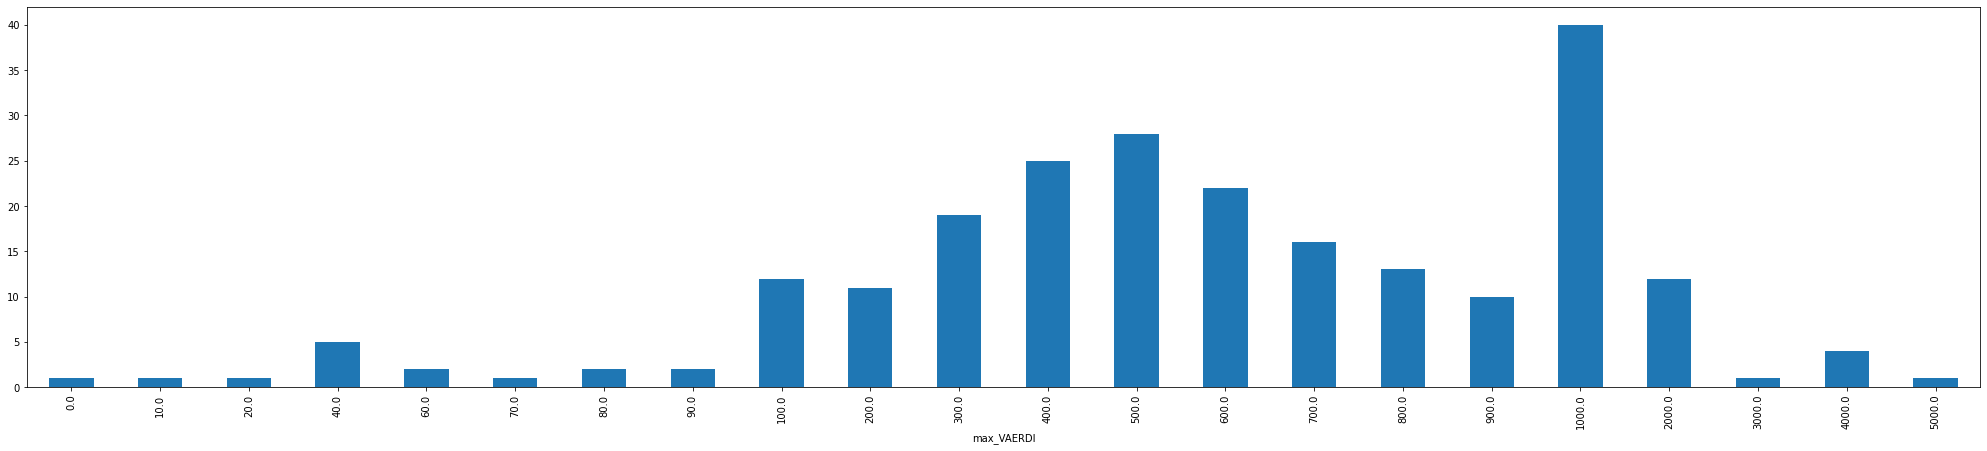

In [195]:
plt.figure(figsize=(35,7))
windmill_PL.groupby("max_VAERDI").count()["GSRN"].plot.bar()

In [196]:
windmill_PL_SC = windmill_PL[windmill_PL["max_VAERDI"] == 500]

In [197]:
windmill_PL_SC.to_csv('data/windmill_PL_SC.csv', index=False)

# Park and Hav

In [198]:
windmill_PH = windmills[windmills["Turbine_type"]=="P"][windmills["Placement"]=="HAV"]
windmill_PH

,GSRN,Turbine_type,Parent_GSRN,BBR_municipal,Placement,UTM_x,UTM_y,Capacity_kw,Rotor_diameter,Navhub_height,In_service,grid,Aspect,Slope,Elevation,Roughness,max_VAERDI
582,570714700000050442,P,NaN,101,HAV,730693.761000,6.176932e+06,20000.0,76.0,64.0,2000-12-27,653,-1.0,0.0,0.0,0.001,20000.0
585,570714700000050473,P,NaN,101,HAV,730597.242000,6.178754e+06,20000.0,76.0,64.0,2000-12-27,653,-1.0,0.0,0.0,0.001,20000.0
590,570714700000050619,P,NaN,360,HAV,675503.387681,6.047824e+06,165600.0,82.4,68.8,2003-06-17,686,-1.0,0.0,0.0,0.001,200000.0
1437,570715000000023965,P,NaN,727,HAV,584590.760000,6.203445e+06,5000.0,39.0,45.0,1995-05-30,988,-1.0,0.0,0.0,0.001,1000.0
2740,570715000000061752,P,NaN,561,HAV,426733.000000,6.149502e+06,160000.0,80.0,70.0,2002-07-29,1360,-1.0,0.0,0.0,0.001,40000.0
2741,570715000000062582,P,NaN,665,HAV,452081.817500,6.280558e+06,8000.0,80.0,78.0,2002-12-22,1368,-1.0,0.0,0.0,0.001,2000.0
2742,570715000000062636,P,NaN,665,HAV,452393.940000,6.279459e+06,9200.0,82.4,78.8,2003-01-21,1368,-1.0,0.0,0.0,0.001,2000.0
2884,570715000000086489,P,NaN,561,HAV,410813.087912,6.162455e+06,209300.0,93.0,55.0,2009-05-13,1403,-1.0,0.0,0.0,0.001,50000.0
2934,570715000000088735,P,NaN,330,HAV,624318.064286,6.134789e+06,21000.0,90.0,80.0,2009-10-28,859,-1.0,0.0,0.0,0.001,5000.0
2944,570715000000089299,P,NaN,360,HAV,664492.611111,6.048460e+06,207000.0,92.6,80.0,2010-04-01,686,-1.0,0.0,0.0,0.001,50000.0


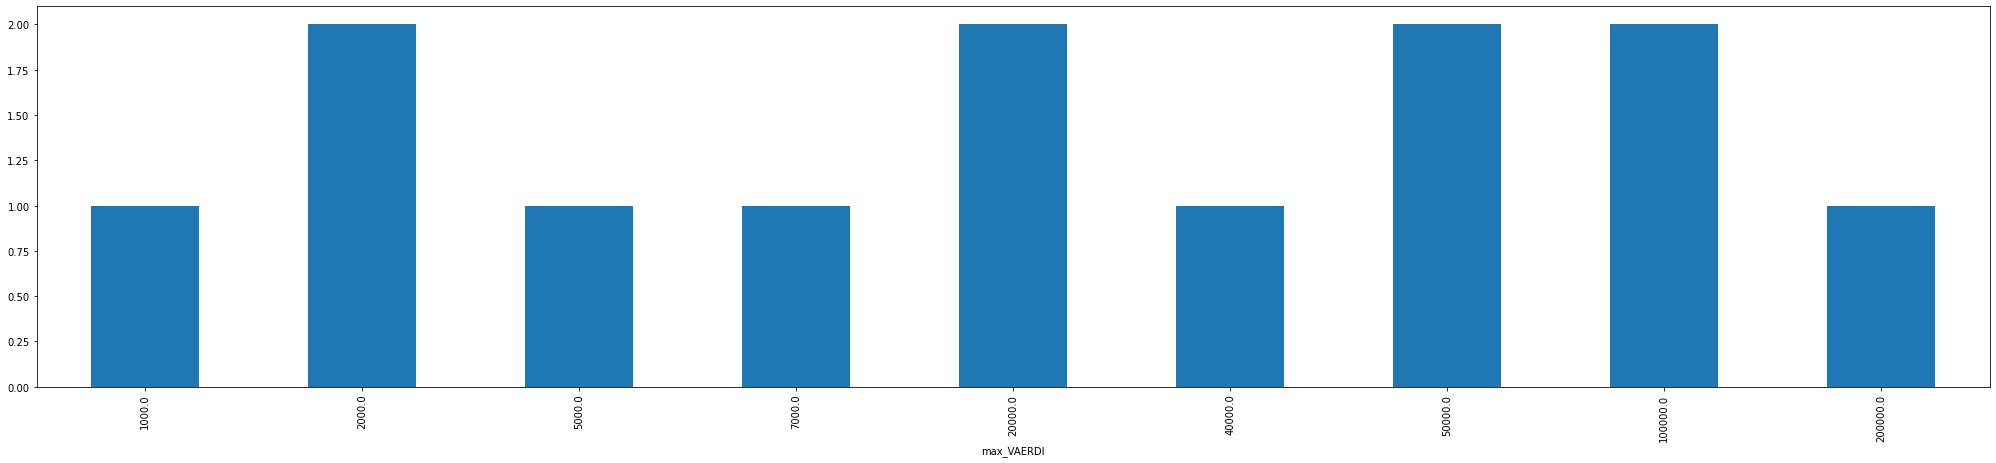

In [199]:
plt.figure(figsize=(35,7))
windmill_PH.groupby("max_VAERDI").count()["GSRN"].plot.bar()


In [200]:
windmill_PH_SC = windmill_PH[windmill_PH["max_VAERDI"] == 20000]

In [201]:
windmill_PH_SC

,GSRN,Turbine_type,Parent_GSRN,BBR_municipal,Placement,UTM_x,UTM_y,Capacity_kw,Rotor_diameter,Navhub_height,In_service,grid,Aspect,Slope,Elevation,Roughness,max_VAERDI
582,570714700000050442,P,NaN,101,HAV,730693.761,6176932.296,20000.0,76.0,64.0,2000-12-27,653,-1.0,0.0,0.0,0.001,20000.0
585,570714700000050473,P,NaN,101,HAV,730597.242,6178754.028,20000.0,76.0,64.0,2000-12-27,653,-1.0,0.0,0.0,0.001,20000.0


In [202]:
windmill_PH_SC.to_csv('data/windmill_PH_SC.csv', index=False)

# Windmill Single Classify by max_VAERDI

In [203]:
windmills = pd.read_csv('data/windmill_cleaned.csv', dtype=dtype)

## Single and LAND

In [204]:
windmill_SL = windmills[windmills["Placement"] == "LAND"][windmills["Turbine_type"] == "W"].reset_index(drop=True)
len(windmill_SL)

3049

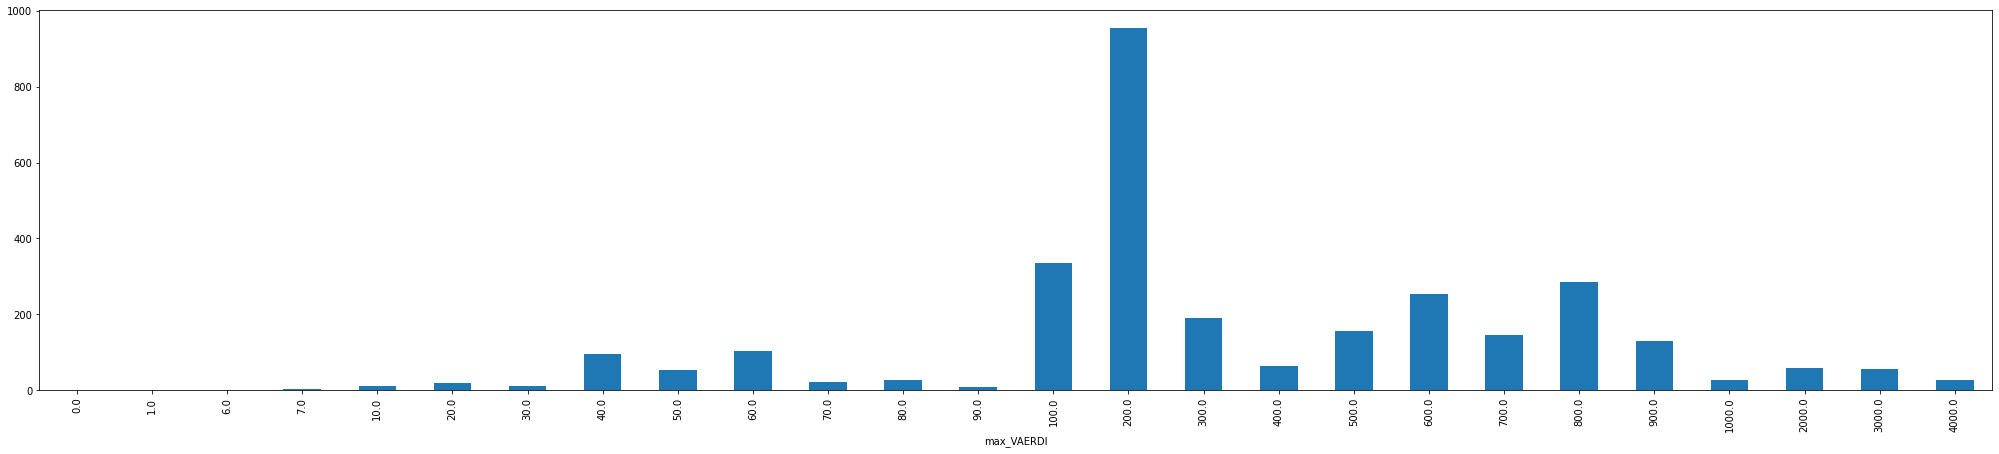

In [205]:
plt.figure(figsize=(35,7))
windmill_SL.groupby("max_VAERDI").count()["GSRN"].plot.bar()

### Select max_VAERDI == 200

In [206]:
windmill_SL_SC = windmill_SL[windmill_SL["max_VAERDI"] == 200]
len(windmill_SL_SC)

955

In [207]:
windmill_SL_SC.to_csv("data/windmill_SL_SC.csv", index=False)

## Single and Hav

In [208]:
windmill_SH = windmills[windmills["Placement"] == "HAV"][windmills["Turbine_type"] == "W"].reset_index(drop=True)
len(windmill_SH)

16

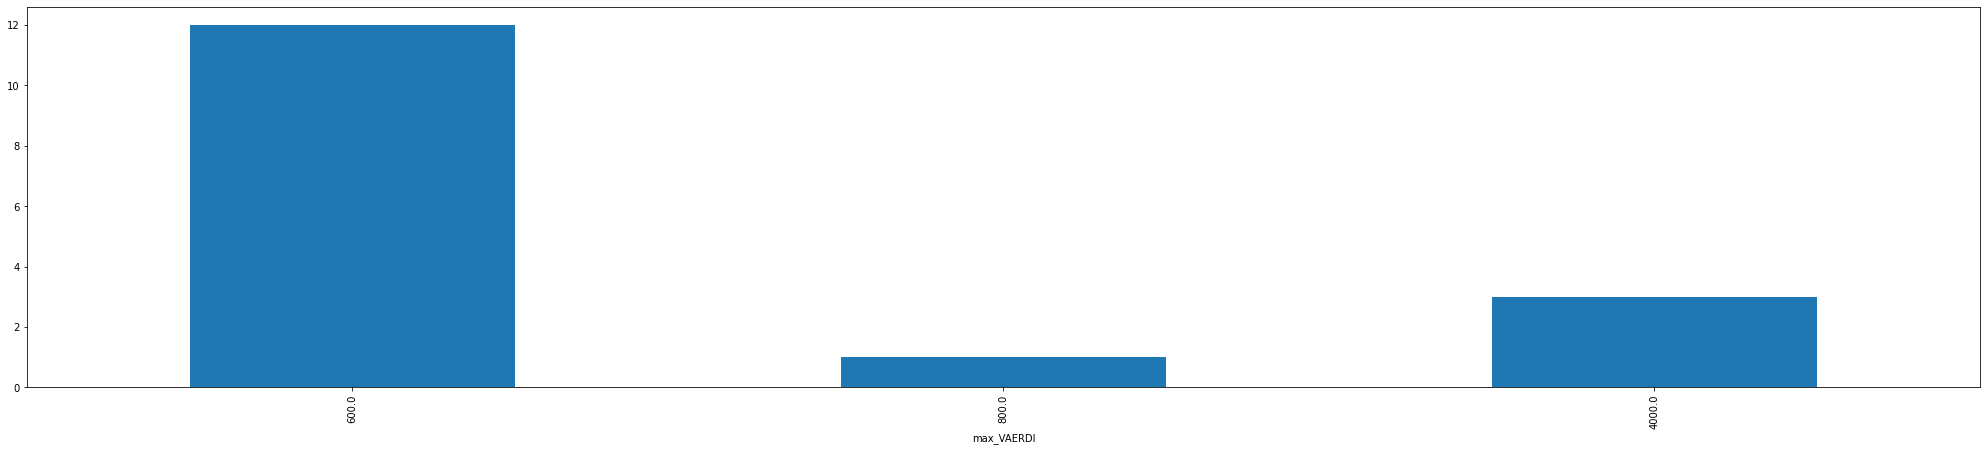

In [209]:
plt.figure(figsize=(35,7))
windmill_SH.groupby("max_VAERDI").count()["GSRN"].plot.bar()

In [211]:
windmill_SH_SC = windmill_SH[windmill_SH["max_VAERDI"] == 600]
len(windmill_SH_SC)

12

In [212]:
windmill_SH_SC.to_csv("data/windmill_SH_SC.csv", index=False)